<a href="https://colab.research.google.com/github/anitayadav3/EmotionRecognitionInConversation/blob/master/WordEmbedding_Glove_With_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pickle
import pandas as pd
import numpy as np
import keras
import itertools
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Input
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical  

from keras.layers import Layer
import keras.backend as K

In [3]:
glove_6B_100d_file_path_name = "/content/gdrive/My Drive/iemocap/glove.6B.100d.txt"

embeddings_index = dict()

f = open(glove_6B_100d_file_path_name)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [4]:
all_glove_words = list(embeddings_index.keys())
vocabulary_size = len(all_glove_words)
tokenizer = Tokenizer() #num_words= vocabulary_size
tokenizer.fit_on_texts(all_glove_words)

In [5]:
print(len(all_glove_words))

400000


In [6]:
embedding_matrix = np.zeros((vocabulary_size, 100)) 
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [7]:
with open('/content/gdrive/My Drive/iemocap/train/sentences.pkl', 'rb') as f:
    data = pickle.load(f)
with open('/content/gdrive/My Drive/iemocap/train/labels.pkl', 'rb') as f:
    labels = pickle.load(f)
with open('/content/gdrive/My Drive/iemocap/test/sentences.pkl', 'rb') as f:
    test_data = pickle.load(f)
with open('/content/gdrive/My Drive/iemocap/test/labels.pkl', 'rb') as f:
    test_labels = pickle.load(f)

In [8]:
def preprocessing(data,labels):
  processed_data=[]
  processed_label=[]
  for i in range(0,len(data)):
    for j in range(0,len(data[i])):
      intermediate_data=[]
      intermediate_label=[]
      for k in range(0,len(data[i][j])):
        text=data[i][j][k]
        if text != '<eos>'and text!='<pad>':
          intermediate_data.append(text)
      processed_data.append(intermediate_data)
  for i in labels:
    for j in i:
      processed_label.append(j)
  return processed_data,processed_label

In [9]:
processed_data,processed_label = preprocessing(data,labels)
test_processed_data,test_processed_label = preprocessing(test_data,test_labels)

In [10]:
def Tokenize(processed_data,processed_label):
  X = tokenizer.texts_to_sequences(processed_data)
  X = pad_sequences(X)
  Y = to_categorical(processed_label, num_classes=6)
  return X,Y

In [11]:
X,Y = Tokenize(processed_data, processed_label)
test_X , test_Y = Tokenize(test_processed_data,test_processed_label)

In [12]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [13]:
inputs=Input((X.shape[1],))
x=Embedding(input_dim=len(all_glove_words),output_dim=32,input_length=X.shape[1],\
            embeddings_regularizer=keras.regularizers.l2(.001))(inputs)
att_in=LSTM(200,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)
att_out=attention()(att_in)
outputs=Dense(6,activation='softmax')(att_out)
model=Model(inputs,outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 29, 32)            12800000  
_________________________________________________________________
lstm (LSTM)                  (None, 29, 200)           186400    
_________________________________________________________________
attention (attention)        (None, 200)               229       
_________________________________________________________________
dense (Dense)                (None, 6)                 1206      
Total params: 12,987,835
Trainable params: 12,987,835
Non-trainable params: 0
_________________________________________________________________


In [14]:
# lstm_out = 200
# embed_dim=100
# model = Sequential()
# model.add(Embedding(len(all_glove_words), embed_dim,input_length = X.shape[1],weights=[embedding_matrix],trainable=False))
# model.add(Bidirectional(LSTM(200)))
# model.add(Dense(6,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
history=model.fit(X, Y, epochs = 100,  verbose = 1)
score,acc=model.evaluate(test_X,test_Y,verbose=2)
print("Accuracy : "+ str(acc))

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


147/147 [==============================] - 25s 167ms/step - loss: 2.7646 - accuracy: 0.2539
Epoch 2/100
147/147 [==============================] - 24s 166ms/step - loss: 1.7120 - accuracy: 0.2809
Epoch 3/100
147/147 [==============================] - 24s 166ms/step - loss: 1.6668 - accuracy: 0.3120
Epoch 4/100
147/147 [==============================] - 24s 166ms/step - loss: 1.5914 - accuracy: 0.3452
Epoch 5/100
147/147 [==============================] - 24s 167ms/step - loss: 1.5234 - accuracy: 0.3856
Epoch 6/100
147/147 [==============================] - 24s 166ms/step - loss: 1.4505 - accuracy: 0.4339
Epoch 7/100
147/147 [==============================] - 25s 167ms/step - loss: 1.3791 - accuracy: 0.4690
Epoch 8/100
147/147 [==============================] - 24s 165ms/step - loss: 1.3334 - accuracy: 0.4912
Epoch 9/100
147/147 [==============================] - 24s 165ms/step - loss: 1.2772 - accuracy: 0.5210
Epoch 10/100
147/147 [==============================] - 25s 167ms/step - los

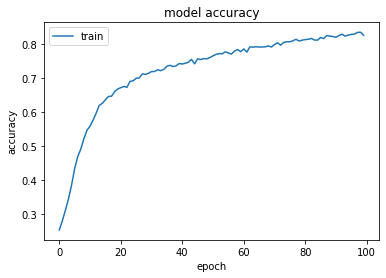

In [16]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()